In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from copy import deepcopy
from xopt.generators.bayesian import BayesianExplorationGenerator
from xopt.vocs import VOCS

vocs = VOCS(
    variables = {"x":[0,1]},
    objectives = {"y":"MAXIMIZE"},
    constraints = {"c": ["LESS_THAN", 0]}
)
generator = BayesianExplorationGenerator(vocs)

<AxesSubplot:>

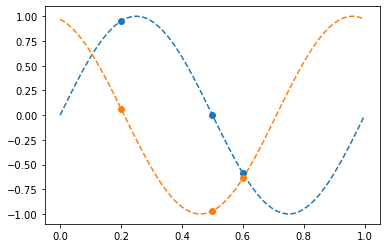

In [2]:
# define test functions
def y(x):
    return torch.sin(2*3.14*x)

def c(x):
    return torch.cos(2*3.14*x + 0.25)

test_x = torch.linspace(*torch.tensor(vocs.bounds.flatten()), 100)

# define training data to pass to the generator
train_x = torch.tensor((0.2,0.5, 0.6))
train_y = y(train_x)
train_c = c(train_x)

data = pd.DataFrame(
    {"x": train_x.numpy(), "y": train_y.numpy(), "c": train_c}
)

def plot_ground_truth():
    fig,ax = plt.subplots()
    ax.plot(test_x, y(test_x),'--C0')
    ax.plot(test_x, c(test_x),'--C1')
    ax.plot(train_x, train_y,'oC0')
    ax.plot(train_x, train_c,'oC1')

    return ax
plot_ground_truth()

# Normal Model with Standard transforms and no constraints
- acquisition function should be symmetric

/usr/share/miniconda/envs/xopt-dev/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1811: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660136119739/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


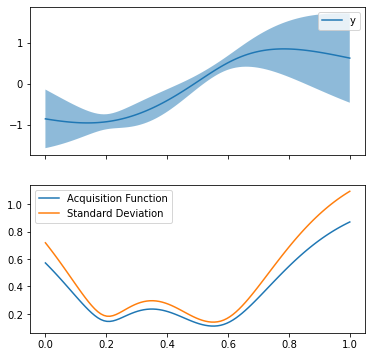

In [3]:
# plot the generator model and acquisition function
generator = BayesianExplorationGenerator(deepcopy(vocs), BayesianExplorationGenerator.default_options())
generator.vocs.constraints = {}

model = generator.train_model(data)

fig,ax = plt.subplots(2,1, sharex="all")
fig.set_size_inches(6,6)
with torch.no_grad():
    post = model.posterior(test_x.reshape(-1,1,1))
    mean = post.mean
    std = torch.sqrt(post.variance)

    l = mean - std
    u = mean + std

    acq = generator.get_acquisition(model)(test_x.reshape(-1,1,1).double())

    for i in range(mean.shape[-1]):
        ax[0].plot(test_x, mean[...,i],f"C{i}", label=generator.vocs.output_names[i])
        ax[0].fill_between(test_x, l[...,i].flatten(), u[...,i].flatten(), alpha=0.5)
    ax[0].legend()

    ax[1].plot(test_x, acq, label='Acquisition Function')
    ax[1].plot(test_x, std[...,0], label='Standard Deviation')
    ax[1].legend()

# Normal Model with Standard transforms and constraints

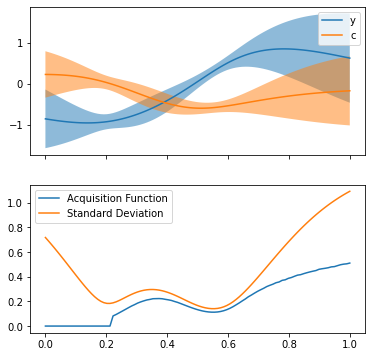

In [4]:
# plot the generator model and acquisition function
generator = BayesianExplorationGenerator(deepcopy(vocs), BayesianExplorationGenerator.default_options())
generator.vocs.constraints = {"c": ["LESS_THAN", 0]}

model = generator.train_model(data)

fig,ax = plt.subplots(2,1, sharex="all")
fig.set_size_inches(6,6)
with torch.no_grad():
    post = model.posterior(test_x.reshape(-1,1,1))
    mean = post.mean
    std = torch.sqrt(post.variance)

    l = mean - std
    u = mean + std

    acq = generator.get_acquisition(model)(test_x.reshape(-1,1,1).double())

    for i in range(mean.shape[-1]):
        ax[0].plot(test_x, mean[...,i],f"C{i}", label=generator.vocs.output_names[i])
        ax[0].fill_between(test_x, l[...,i].flatten(), u[...,i].flatten(), alpha=0.5)
    ax[0].legend()

    ax[1].plot(test_x, acq, label='Acquisition Function')
    ax[1].plot(test_x, std[...,0], label='Standard Deviation')
    ax[1].legend()

# Normal Model with Standard transforms, constraints and conservative prior mean
- acquisition function should be heavily biased away from the sides due to the prior
mean

models.0.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([0.0590], dtype=torch.float64, requires_grad=True)
models.0.mean_module.raw_constant:0.063105532822404
models.0.covar_module.raw_outputscale:2.865802668336045
models.0.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[-0.7458]], dtype=torch.float64, requires_grad=True)
models.1.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([0.0158], dtype=torch.float64, requires_grad=True)
models.1.mean_module.raw_constant:5.0
models.1.covar_module.raw_outputscale:9.123304381621242
models.1.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[-0.0806]], dtype=torch.float64, requires_grad=True)


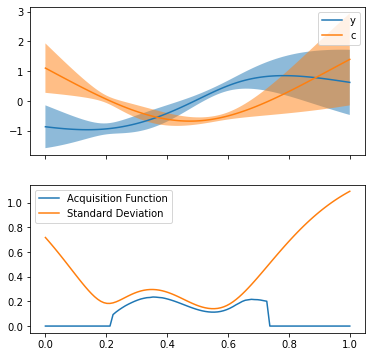

In [5]:
# plot the generator model and acquisition function
generator = BayesianExplorationGenerator(deepcopy(vocs), BayesianExplorationGenerator.default_options())
generator.options.model.use_conservative_prior_mean = True

model = generator.train_model(data)

for name, param in model.named_parameters():
    print(f"{name}:{param}")


fig,ax = plt.subplots(2,1, sharex="all")
fig.set_size_inches(6,6)
with torch.no_grad():
    post = model.posterior(test_x.reshape(-1,1,1))
    mean = post.mean
    std = torch.sqrt(post.variance)

    l = mean - std
    u = mean + std

    acq = generator.get_acquisition(model)(test_x.reshape(-1,1,1).double())

    for i in range(mean.shape[-1]):
        ax[0].plot(test_x, mean[...,i],f"C{i}", label=generator.vocs.output_names[i])
        ax[0].fill_between(test_x, l[...,i].flatten(), u[...,i].flatten(), alpha=0.5)
    ax[0].legend()

    ax[1].plot(test_x, acq, label='Acquisition Function')
    ax[1].plot(test_x, std[...,0], label='Standard Deviation')
    ax[1].legend()

# Conservative Model with Standard transforms, constraints and conservative prior mean
- acquisition function should be heavily biased away from the sides due to the prior
mean
- make sure to use a strong prior on the noise to reduce it

models.0.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([-16.0685], dtype=torch.float64, requires_grad=True)
models.0.mean_module.raw_constant:0.2221716631206893
models.0.covar_module.raw_outputscale:3.0726795649947394
models.0.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[-0.7308]], dtype=torch.float64, requires_grad=True)
models.1.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([-14.6527], dtype=torch.float64, requires_grad=True)
models.1.mean_module.raw_constant:5.0
models.1.covar_module.raw_outputscale:6.996259833399096
models.1.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[-2.1556]], dtype=torch.float64, requires_grad=True)
tensor([[0.1096]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)


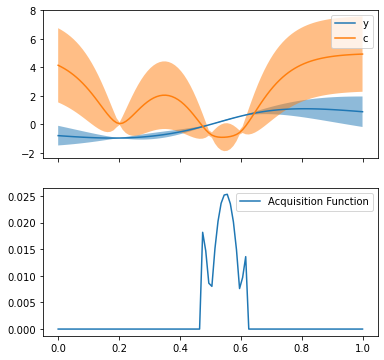

In [6]:
# plot the generator model and acquisition function
generator = BayesianExplorationGenerator(deepcopy(vocs), BayesianExplorationGenerator.default_options())
generator.options.model.use_conservative_prior_mean = True
generator.options.model.use_conservative_prior_lengthscale = True
generator.options.model.use_low_noise_prior = True

model = generator.train_model(data)

for name, param in model.named_parameters():
    print(f"{name}:{param}")

print(model.models[1].covar_module.base_kernel.lengthscale)

fig,ax = plt.subplots(2,1, sharex="all")
fig.set_size_inches(6,6)
with torch.no_grad():
    post = model.posterior(test_x.reshape(-1,1,1))
    mean = post.mean
    std = torch.sqrt(post.variance)

    l = mean - std
    u = mean + std

    acq = generator.get_acquisition(model)(test_x.reshape(-1,1,1).double())

    for i in range(mean.shape[-1]):
        ax[0].plot(test_x, mean[...,i],f"C{i}", label=generator.vocs.output_names[i])
        ax[0].fill_between(test_x, l[...,i].flatten(), u[...,i].flatten(), alpha=0.5)
    ax[0].legend()

    ax[1].plot(test_x, acq, label='Acquisition Function')
    #ax[1].plot(test_x, std[...,0], label='Standard Deviation')
    ax[1].legend()

# Normal model with standard transforms and proximal biasing

models.0.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([0.0590], dtype=torch.float64, requires_grad=True)
models.0.mean_module.raw_constant:0.063105532822404
models.0.covar_module.raw_outputscale:2.865802668336045
models.0.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[-0.7458]], dtype=torch.float64, requires_grad=True)
models.1.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([0.0294], dtype=torch.float64, requires_grad=True)
models.1.mean_module.raw_constant:-0.11693665821945935
models.1.covar_module.raw_outputscale:0.5542011977606083
models.1.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[-0.7846]], dtype=torch.float64, requires_grad=True)
tensor([[0.3759]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)


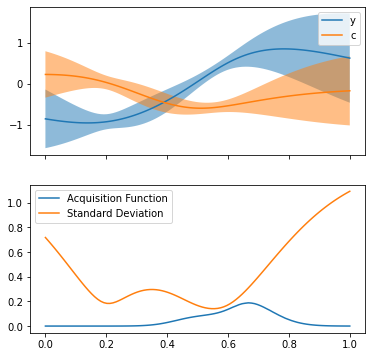

In [7]:
# plot the generator model and acquisition function
generator = BayesianExplorationGenerator(deepcopy(vocs), BayesianExplorationGenerator.default_options())
generator.options.acq.proximal_lengthscales = [0.1]

model = generator.train_model(data)

for name, param in model.named_parameters():
    print(f"{name}:{param}")

print(model.models[1].covar_module.base_kernel.lengthscale)

fig,ax = plt.subplots(2,1, sharex="all")
fig.set_size_inches(6,6)
with torch.no_grad():
    post = model.posterior(test_x.reshape(-1,1,1))
    mean = post.mean
    std = torch.sqrt(post.variance)

    l = mean - std
    u = mean + std

    acq = generator.get_acquisition(model)(test_x.reshape(-1,1,1).double())

    for i in range(mean.shape[-1]):
        ax[0].plot(test_x, mean[...,i],f"C{i}", label=generator.vocs.output_names[i])
        ax[0].fill_between(test_x, l[...,i].flatten(), u[...,i].flatten(), alpha=0.5)
    ax[0].legend()

    ax[1].plot(test_x, acq, label='Acquisition Function')
    ax[1].plot(test_x, std[...,0], label='Standard Deviation')
    ax[1].legend()

models.0.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([0.0590], dtype=torch.float64, requires_grad=True)
models.0.mean_module.raw_constant:0.063105532822404
models.0.covar_module.raw_outputscale:2.865802668336045
models.0.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[-0.7458]], dtype=torch.float64, requires_grad=True)
models.1.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([0.0158], dtype=torch.float64, requires_grad=True)
models.1.mean_module.raw_constant:5.0
models.1.covar_module.raw_outputscale:9.123304381621242
models.1.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[-0.0806]], dtype=torch.float64, requires_grad=True)
tensor([[0.6537]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)


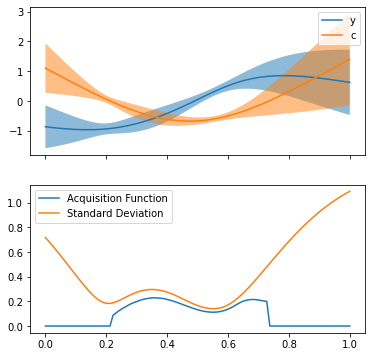

In [8]:
# plot the generator model and acquisition function
generator = BayesianExplorationGenerator(deepcopy(vocs), BayesianExplorationGenerator.default_options())
generator.options.model.use_conservative_prior_mean = True
generator.options.model.use_conservative_prior_lengthscale = False
generator.options.acq.proximal_lengthscales = [1.1]


model = generator.train_model(data)

for name, param in model.named_parameters():
    print(f"{name}:{param}")

print(model.models[1].covar_module.base_kernel.lengthscale)

fig,ax = plt.subplots(2,1, sharex="all")
fig.set_size_inches(6,6)
with torch.no_grad():
    post = model.posterior(test_x.reshape(-1,1,1))
    mean = post.mean
    std = torch.sqrt(post.variance)

    l = mean - std
    u = mean + std

    acq = generator.get_acquisition(model)(test_x.reshape(-1,1,1).double())

    for i in range(mean.shape[-1]):
        ax[0].plot(test_x, mean[...,i],f"C{i}", label=generator.vocs.output_names[i])
        ax[0].fill_between(test_x, l[...,i].flatten(), u[...,i].flatten(), alpha=0.5)
    ax[0].legend()

    ax[1].plot(test_x, acq, label='Acquisition Function')
    ax[1].plot(test_x, std[...,0], label='Standard Deviation')
    ax[1].legend()